In [6]:
import json
import numpy as np
import torch
from torch import nn
from torch.utils import data
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [8]:
with open('./testdump_1.txt') as f:
    json_data = json.load(f)

In [9]:
states = []
actions = []
for sa in json_data:
    states.append(np.array([float(x) for x in sa["state"]["ai_1"]]))
    actions.append(int(sa["ai_1"]))

In [10]:
num_states = len(states[0])
num_actions = max(actions) + 1
print(num_states, num_actions)

39 40


In [11]:
train_states, test_states, train_actions, test_actions = train_test_split(states, actions, test_size=0.15)
tensor_train_states = torch.Tensor(train_states)
tensor_train_actions = torch.Tensor(train_actions)
tensor_test_states = torch.Tensor(test_states)
tensor_test_actions = torch.Tensor(test_actions)

train_dataset = data.TensorDataset(tensor_train_states, tensor_train_actions)
train_dataloader = data.DataLoader(train_dataset, batch_size=64, shuffle=True) 
test_dataset = data.TensorDataset(tensor_test_states, tensor_test_actions)
test_dataloader = data.DataLoader(test_dataset, batch_size=64) 

In [31]:
class BCAgent(nn.Module):
    def __init__(self):
        super().__init__()
        self.agent = nn.Sequential(
            nn.Linear(num_states, 40),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(40, num_actions)
        ).to(device)
    
    def forward(self, x):
        return self.agent(x)
    
    def save_state(self, path):
        torch.save(self.agent.state_dict(), path)
    
    def load_state(self, path):
        self.agent.load_state_dict(torch.load(path))

bc_agent = BCAgent()
optimizer = torch.optim.Adam(bc_agent.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss(weight=torch.Tensor([0.1] + [1] * (num_actions - 1)).to(device))

In [17]:
train_total_losses = []
test_total_losses = []
for epoch in range(200):
    train_total_loss = 0
    train_steps = 0
    for s, a in train_dataloader:
        s = s.float().to(device)
        a = a.long().to(device)
    
        loss = loss_func(bc_agent(s), a)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_steps += 1
        train_total_loss += loss.detach().cpu().numpy()
    train_total_losses.append(train_total_loss / train_steps)
    
    test_total_loss = 0
    test_steps = 0
    for s, a in test_dataloader:
        s = s.float().to(device)
        a = a.long().to(device)
        loss = loss_func(bc_agent(s), a)
        
        test_steps += 1
        test_total_loss += loss.detach().cpu().numpy()
    test_total_losses.append(test_total_loss / test_steps)
    print(f"Epoch {epoch:<5} Train Loss: {train_total_losses[-1]:<5.2f} Test Loss: {test_total_losses[-1]:<5.2f}")

Epoch 0     Train Loss: 6.18  Test Loss: 3.40 
Epoch 1     Train Loss: 3.06  Test Loss: 2.63 
Epoch 2     Train Loss: 2.50  Test Loss: 2.21 
Epoch 3     Train Loss: 2.33  Test Loss: 2.00 
Epoch 4     Train Loss: 2.13  Test Loss: 1.91 
Epoch 5     Train Loss: 2.03  Test Loss: 1.79 
Epoch 6     Train Loss: 2.00  Test Loss: 1.73 
Epoch 7     Train Loss: 1.91  Test Loss: 1.78 
Epoch 8     Train Loss: 1.88  Test Loss: 1.73 
Epoch 9     Train Loss: 1.82  Test Loss: 1.73 
Epoch 10    Train Loss: 1.80  Test Loss: 1.71 
Epoch 11    Train Loss: 1.76  Test Loss: 1.63 
Epoch 12    Train Loss: 1.76  Test Loss: 1.56 
Epoch 13    Train Loss: 1.72  Test Loss: 1.50 
Epoch 14    Train Loss: 1.74  Test Loss: 1.59 
Epoch 15    Train Loss: 1.69  Test Loss: 1.60 
Epoch 16    Train Loss: 1.69  Test Loss: 1.55 
Epoch 17    Train Loss: 1.65  Test Loss: 1.51 
Epoch 18    Train Loss: 1.62  Test Loss: 1.45 
Epoch 19    Train Loss: 1.66  Test Loss: 1.50 
Epoch 20    Train Loss: 1.61  Test Loss: 1.60 
Epoch 21    T

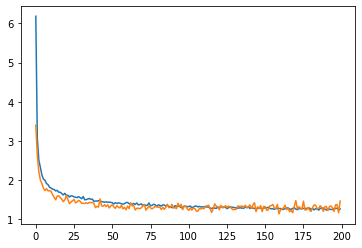

In [18]:
plt.plot(range(len(train_total_losses)), train_total_losses)
plt.plot(range(len(test_total_losses)), test_total_losses)
plt.show()

In [21]:
bc_agent.save_state('./bc_agent')

In [39]:
import melee
from melee import SSBMEnv

with torch.no_grad():
    bc_agent = BCAgent()
    bc_agent.load_state('bc_agent')
    env = SSBMEnv('../mocker/dolphin-emu.app/Contents/MacOS', ssbm_iso_path='../mocker/m.iso')
    obs = env.reset()
    done = False
    while not done:
        logits = bc_agent(torch.FloatTensor(obs['ai_1'], device=device))
        action = torch.distributions.categorical.Categorical(logits=logits).sample()
        joint_action = {'ai_1': action}
        obs, reward, done, info = env.step(joint_action)
        done = done['__all__']

Connecting to console...
Connecting controller to console...
Controllers connected


_start_game took too long
Exception in thread Thread-16:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/threading.py", line 1254, in run
    self.function(*self.args, **self.kwargs)
  File "/Users/praveen/Drive-berkeley/cal5/lp/bRawL/libmelee/melee/utils.py", line 13, in quit_function
    raise TimeoutException("timeout!")
melee.utils.TimeoutException: timeout!


{'ai_1': array([  1., -60.,  10.,   0.,  60.,   1., 322.,  -1.,   0.,   0.,   0.,
         0.,   1.,   0.,   0.,   0.,   0.,   0.,   0., 120.,  22.,  60.,
        10.,   0.,  60.,   0., 322.,  -1.,   0.,   0.,   0.,   0.,   1.,
         0.,   0.,   0.,   0.,   0.,   0.])}
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(29)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(8)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(27)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(25)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(25)
tensor(0)
tensor(27)
tensor(30)
tensor(29)
tensor(0)
tensor(0)
tensor(36)
tensor(29)
tensor(0

KeyboardInterrupt: 